# Project: Amazon Product Recommendation System

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

Our goal, as a Data Science Manager at Amazon, is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

# Files & Installatiom

In [1]:
#!kill -9 -1

In [2]:
#/content/drive/MyDrive/ratings_Electronics.csv

In [3]:
from google.colab import drive
drive.mount(r'/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
!pip install surprise

# Importing libraries and overview of the dataset

In [5]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from sklearn.metrics import mean_squared_error

import torch

In [6]:
print(torch.cuda.get_device_name(0))

Tesla T4


In [7]:
dataset = pd.read_csv('/content/drive/MyDrive/ratings_Electronics.csv', header = None)

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       object 
 1   1       object 
 2   2       float64
 3   3       int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [9]:
dataset.columns = ['user_id', 'prod_id', 'rating', 'timestamp']
dataset = dataset.drop('timestamp', axis = 1)
df = dataset.copy(deep = True)

In [10]:
users = df.user_id

ratings_count = dict()

for user in users:
  if user in ratings_count:
    ratings_count[user] += 1

  else:
    ratings_count[user] = 1


In [11]:
ratings_cutoff = 50

remove_users = []

for user, num_ratings in ratings_count.items():
  if num_ratings < ratings_cutoff:
    remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [12]:
products = df.prod_id

ratings_count = dict()

for prod in products:

  if prod in ratings_count:
    ratings_count[prod] += 1

  else:
    ratings_count[prod] = 1

In [13]:
ratings_cutoff = 5

remove_users = []

for user, num_ratings in ratings_count.items():
  if num_ratings < ratings_cutoff:
    remove_users.append(users)

df_final = df.loc[ ~ df.user_id.isin(remove_users)]

In [14]:
df_final.head(10)

,user_id,prod_id,rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0
631,A3TAS1AG6FMBQW,0972683275,5.0
1003,A2Y4H3PXB07WQI,0972683275,4.0
1138,A25RTRAPQAJBDJ,0972683275,5.0
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0


# EDA

In [15]:
dataset.shape


(7824482, 3)

After dropping the time stamp column we have three remainders, we have over 7 million rows meaning that this is a large data set

In [16]:
df_final.info()
rows, columns = df_final.shape
print('Number of rows: ', rows, 'Number of columns: ', columns)

<class 'pandas.core.frame.DataFrame'>
Index: 125871 entries, 94 to 7824444
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  125871 non-null  object 
 1   prod_id  125871 non-null  object 
 2   rating   125871 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.8+ MB
Number of rows:  125871 Number of columns:  3


Our d-types are object for user id and product id, For ratings we have 64 float which makes sense as the user ids and product ids are unique nomenclatures whilst the ratings are numeric.

In [17]:
df_final.isnull().sum()

,0
user_id,0
prod_id,0
rating,0


There is no missing data in any of our columns.

In [18]:
interaction_count = df_final.groupby(['user_id', 'prod_id']).count()
interaction_count.head(10)

rating
user_id        prod_id           
A100UD67AHFODS B00004Z5M1       1
               B00005T3X7       1
               B000069EUW       1
               B000069JWX       1
               B0000AR0I4       1
               B0001D3K8A       1
               B000233WJ6       1
               B0002HJGUQ       1
               B0002KVQBA       1
               B0002SQ2P2       1

In [19]:
df_final['prod_id']= df_final['prod_id'].astype(str)

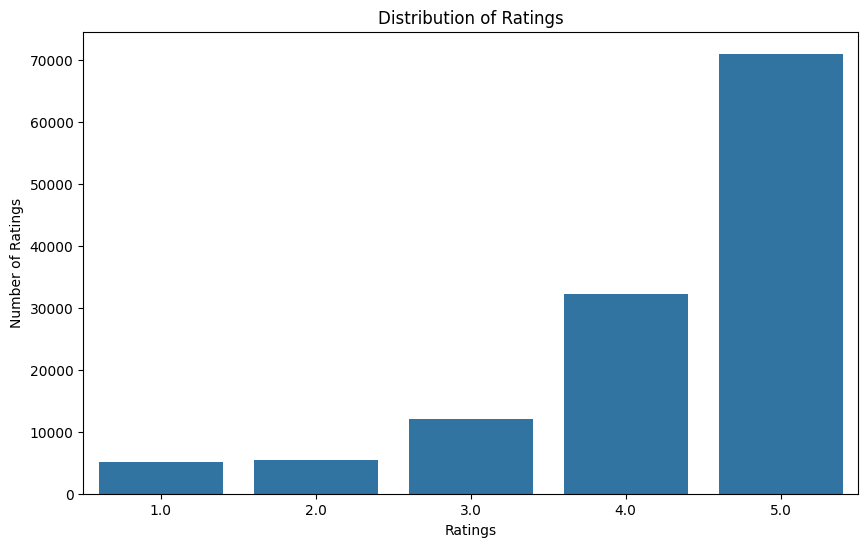

In [20]:
plt.figure(figsize = (10, 6))
sns.countplot(x="rating", data=df_final)
plt.title("Distribution of Ratings")
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings")
plt.show()

Our data set is right skewed which may mean our trained data may tends towards higher ratings.

In [21]:
df_final.describe([]).T

,count,mean,std,min,50%,max
rating,125871.0,4.261339,1.062144,1.0,5.0,5.0


Our description further reflects the right skew with a mean of 4.26 for rating.

In [22]:
df_final.nunique()

,0
user_id,1540
prod_id,48190
rating,5


In [23]:
df_final['prod_id'].value_counts()

,count
prod_id,
B0088CJT4U,206
B003ES5ZUU,184
B000N99BBC,167
B007WTAJTO,164
B00829TIEK,149
...,...
B003VOAPN4,1
B003VNKN1O,1
B000HZH6W8,1


Given the ratio between User ID and product ID seems that some of our users are  vastly more likely the radar products than others, Or some products receive a bulk of ratings and reviews.

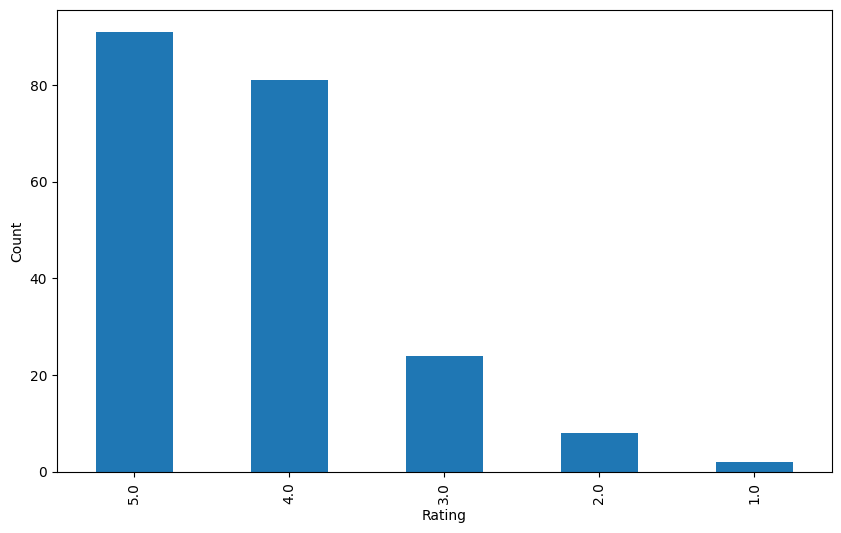

In [24]:
plt.figure(figsize = (10,6))

df_final[df_final['prod_id'] == 'B0088CJT4U']['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

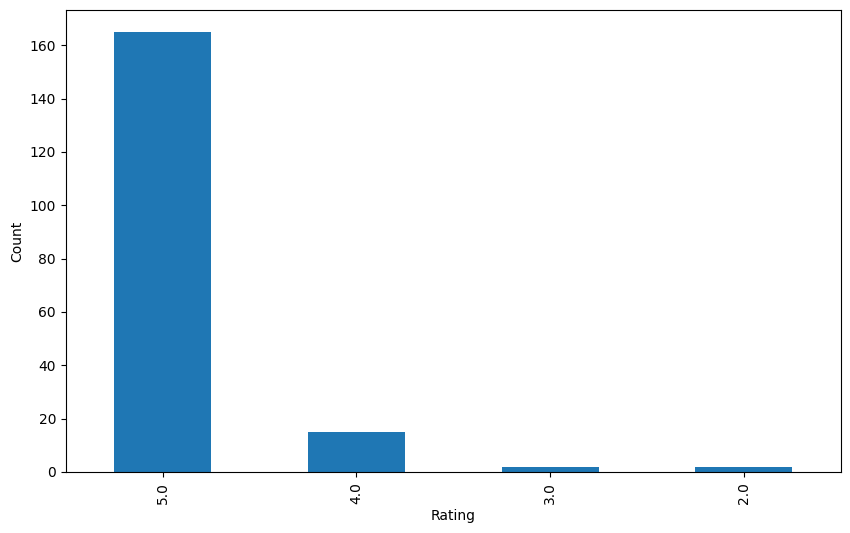

In [25]:
plt.figure(figsize = (10,6))

df_final[df_final['prod_id'] == 'B003ES5ZUU']['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [26]:
most_rated = df_final.groupby('user_id').size().sort_values(ascending= False)[:10]
most_rated

,0
user_id,
A5JLAU2ARJ0BO,520
ADLVFFE4VBT8,501
A3OXHLG6DIBRW8,498
A6FIAB28IS79,431
A680RUE1FDO8B,406
A1ODOGXEYECQQ8,380
A36K2N527TXXJN,314
A2AY4YUOX2N1BQ,311
AWPODHOB4GFWL,308


The user_id 'A5JLAU2ARJ0BO' has the higherst number of products rated at 520

# Model 1:  Rank Based Recommendation System

In [27]:
rating_avg = df_final.groupby('prod_id')['rating'].mean()

rating_count = df_final.groupby('prod_id')['rating'].count()

final_rating = pd.DataFrame({'rating_avg':rating_avg, 'rating_count':rating_count})

final_rating = final_rating.sort_values('rating_avg', ascending= False)

final_rating.head(5).T

prod_id,B00LKG1MC8,0594451647,B00LGQ6HL8,B00LGN7Y3G,B00L8QCVL6
rating_avg,5.0,5.0,5.0,5.0,5.0
rating_count,1.0,1.0,5.0,1.0,1.0


In [28]:
final_rating['rating_count'].value_counts()

,count
rating_count,
1,30835
2,6975
3,2968
4,1723
5,1082
...,...
71,1
79,1
149,1


One of products is an outlier and has been rated more than 30835 times

In [29]:
def top_n_products(final_rating, n, min_interaction):

  recommendations = final_rating[final_rating['rating_count'] > min_interaction]

  recommendations = recommendations.sort_values('rating_avg', ascending = False)

  return recommendations.index[:n]

In [30]:
res = list(top_n_products(final_rating, 5, 50))

list_of_products = [
  df_final[df_final['prod_id']==str(i)]['prod_id'].unique()[0] for i in res
]
list_of_products

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

These are our 5 top rated productts with a minimum of 50 interactions

In [31]:
res = list(top_n_products(final_rating, 5, 100))

list_of_products = [
  df_final[df_final['prod_id']==str(i)]['prod_id'].unique()[0] for i in res
]
list_of_products

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

These are our 5 top rated products with a minimum of 100 interactions

# Model 2: Collaborative Filtering Recomendation System

In [32]:
from surprise import accuracy

from surprise.reader import Reader

from surprise.dataset import Dataset

from surprise.model_selection import GridSearchCV

from surprise.model_selection import train_test_split

from surprise.prediction_algorithms.knns import KNNBasic

from surprise.prediction_algorithms.matrix_factorization import SVD

from surprise.model_selection import KFold

from surprise import CoClustering

In [33]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

In [34]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.3, random_state = 1)


Building the user-user similarity-based recommendation system

In [35]:
sim_options = {'name': 'cosine',
               'user_based': True}

# Instantiating the KNNBasic
algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the train set, and predict ratings for the test set
algo_knn_user.fit(trainset)

# Compute precision @ k, recall @ k, and f1 w/ k = 10
precision_recall_at_k(algo_knn_user, k = 10, threshold = 3.5)

RMSE: 1.1089
Precision:  0.854
Recall:  0.51
F_1 score:  0.639


For this baseline model our RMSE is rated at 1.1 while our precision is at 85%, our F1 score is at 63% and Recall is at 51%. This means relevant only about half of our total items are recommended, out of all items recommended 85% are relevant. Our Recall and F1 scores indicates that this model will need to be fine-tuned.

In [36]:
algo_knn_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui= 5, verbose=True )

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.80   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.8, details={'actual_k': 5, 'was_impossible': False})

For user A3LDPF5FMB782Z, we have a predicted rating of 3.80 while our actual rating is 5.

In [37]:
df_final[df_final.prod_id != "1400501466"].user_id.unique()

array(['A3BY5KCNQZXV5U', 'AT09WGFUM934H', 'A32HSNCNPRUMTR', ...,
       'AT53ZTTO707MB', 'A1X3ESYZ79H59E', 'A328S9RN3U5M68'], dtype=object)

Above is the list of users who have not seen the product with product id "1400501466".

In [38]:
algo_knn_user.predict("A34BZM6S9L7QI4", "1400501466", verbose=True )

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 3.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=3.0, details={'actual_k': 1, 'was_impossible': False})

For user A34BZM6S9L7QI4 and item 1400501466 we have a predicted rating of 3.00, while our r_ui id 0 showing that the user has not actually rated this product.

The gaps in between are predicted estimates in our actual values show that this model may not be the most accurate as it currently is.

Improving similarity based algorithm by tuning it's hyperparameters

In [39]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40, 50], 'min_k': [3,6,9, 12],
              'sim_options': {'name': ['msd', 'cosine'], 'user_based': [True]}}

gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs = -1)

gs.fit(data)

In [40]:
print(gs.best_score['rmse'])

print(gs.best_params['rmse'])

1.0537533400008463
{'k': 50, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


In [41]:
sim_options = {'name': 'cosine', 'user_based': True}

similarity_algo_optimized = KNNBasic(sim_options=sim_options, k = 50, min_k = 6,
                                     random_state =1, verbose=False)

similarity_algo_optimized.fit(trainset)

In [42]:
precision_recall_at_k(similarity_algo_optimized, k = 10, threshold = 3.5)

RMSE: 1.0511
Precision:  0.838
Recall:  0.501
F_1 score:  0.627


Our results as for the scores of this model have not improved but they are not largely different from our original.

In [43]:
similarity_algo_optimized.predict("A3LDPF5FMB782Z", "1400501466", verbose=True )

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.26   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.259735100841004, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

While this user has not actually rated our product it shows that the estimated rating is 4.26

In [44]:
similarity_algo_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.26   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.259735100841004, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [45]:
similarity_algo_optimized.get_neighbors(0,5)

[7, 25, 26, 30, 31]

In [46]:
def get_recommendations(data, user_id, top_n, algo):

  recommendations = []

  user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

  non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

  for item_id in non_interacted_products:

    est = algo.predict(user_id, item_id).est

    recommendations.append((item_id, est))

  recommendations.sort(key = lambda x: x[1], reverse = True)

  return recommendations[:top_n]





In [47]:
print(df_final.columns)

Index(['user_id', 'prod_id', 'rating'], dtype='object')


In [48]:
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, similarity_algo_optimized)

In [49]:
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5
1,B001TH7GUU,5
2,B001V9KG0I,5
3,B002NEGTTW,5
4,B002Y6CJJ8,5


These are the top 5 product recommendations for user A3LDPF5FMB782Z

In [50]:
sim_options = {'name': 'cosine',
               'user_based': False}

sim_item_algo = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

sim_item_algo.fit(trainset)

precision_recall_at_k(sim_item_algo, k = 10, threshold = 3.5)

RMSE: 1.0981
Precision:  0.828
Recall:  0.495
F_1 score:  0.62


In [51]:
sim_item_algo.predict('A3LDPF5FMB782Z', '1400501466', verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.22   {'actual_k': 40, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.225, details={'actual_k': 40, 'was_impossible': False})

For this item we are predicting a rating of 4.22 with this user

In [52]:
#Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20,30], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'], 'user_based': [True]}}

gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs = -1)

gs.fit(data)

Unfornately inputting user base as false causes a crash in my colab session due to the large size of the dataset

In [53]:
print(gs.best_score['rmse'])

1.0537247505986884


In [54]:
print(gs.best_params['rmse'])

{'k': 30, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


In [55]:
sim_options = {'name': 'cosine', 'user_based': True}

sim_items_algo_optimized = KNNBasic(sim_options=sim_options, k = 30, min_k = 6,
                                     random_state =1, verbose=False)
sim_items_algo_optimized.fit(trainset)

precision_recall_at_k(sim_items_algo_optimized, k = 10, threshold = 3.5)

RMSE: 1.0512
Precision:  0.838
Recall:  0.501
F_1 score:  0.627


In [56]:
sim_items_algo_optimized.predict('A3LDPF5FMB782Z', '1400501466', verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.26   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.259735100841004, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [57]:
sim_items_algo_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.26   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.259735100841004, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [58]:
sim_items_algo_optimized.get_neighbors(0,5)

[7, 25, 26, 30, 31]

In [59]:
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_items_algo_optimized)

In [60]:
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B00029U1DK,5
1,B000N99BBC,5
2,B0019EHU8G,5
3,B001TH7GUU,5
4,B001TH7T2U,5


# Model 3: Matrix Factorization

In [61]:
svd = SVD(random_state = 1)

svd.fit(trainset)

precision_recall_at_k(svd, k = 10, threshold = 3.5)

RMSE: 0.9858
Precision:  0.852
Recall:  0.498
F_1 score:  0.629


Our matrix factor shows lowered scores across the board and will need to be fine tuned.

In [62]:
svd.predict('A3LDPF5FMB782Z', '1400501466', verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.24   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.236780458137935, details={'was_impossible': False})

For this product we have an estimated rating og 4.24, this product should be recommend to our user as the score is above 4.

In [63]:
svd.predict("A34BZM6S9L7Q14", "1400501466", verbose = True)

user: A34BZM6S9L7Q14 item: 1400501466 r_ui = None   est = 4.15   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7Q14', iid='1400501466', r_ui=None, est=4.1536091189141855, details={'was_impossible': False})

Improving Matrix Functions based on recommendation systems

In [64]:
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, .005, .01],
              'reg_all': [.2, .4, .6]}

gs2 = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

gs2.fit(data)

print(gs2.best_score['rmse'])

print(gs2.best_params['rmse'])

0.9805845441761049
{'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2}


In [65]:
svd_optimized = SVD(n_epochs=30, lr_all=.005, reg_all=.2, random_state=1 )
svd_optimized.fit(trainset)

precision_recall_at_k(svd_optimized, k = 10, threshold = 3.5)


RMSE: 0.9795
Precision:  0.861
Recall:  0.507
F_1 score:  0.638


In [66]:
svd_optimized.predict('A3LDPF5FMB782Z', '1400501466', verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.15   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.145919320283274, details={'was_impossible': False})

The user predict model estimates a 4.15 rating for this product ID

In [67]:
svd_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.395477149146272, details={'was_impossible': False})

The user predict model estimates a 4.40 rating for this product ID

#Conclusion and Recommendations

The majority of my models perform similarly. These recommendation systems can be used to identify products that the users might be satisfied with. This is no perfect system and would require further fine tuning. My results were limited by collab related ram issues The process demonstrates the usefulness of these models